In [1]:
from typing import Callable

import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.datasets import make_regression

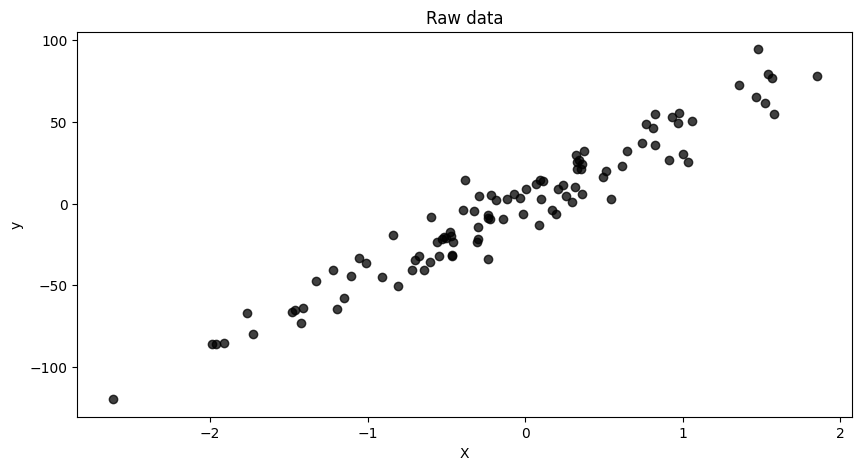

In [2]:
# Generate synthetic linear data
X, y = make_regression(n_samples=100, n_features=1, noise=12.0, random_state=42)
X = X.flatten()

# Plot data and regression line
plt.figure(figsize=(10, 5))
plt.title("Raw data")
plt.scatter(X, y, color="black", alpha=0.75)
plt.xlabel("X")
plt.ylabel("y")
plt.show()
plt.close()

In [3]:
def model(X: np.ndarray, y: np.ndarray | None = None):
    """Bayesian linear regression model.

    Args:
        X: Feature vector of shape (N,)
        y: Target vector of shape (N,). Defaults to None (used for predictions).
    """
    slope = numpyro.sample("slope", dist.Normal(0, 10))
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(5))

    mean = slope * X + intercept

    with numpyro.plate("data", X.shape[0]):  # Use plates for efficient vectorization
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)


# Run MCMC using No U-Turn Sampler (NUTS). This is where the Bayesian magic happens,
# where we sample the posterior distribution of the parameters given the data.
# In classical ML, this would be the gradient descent algorithm (model fitting).
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, X, y)

# Get posterior samples. This is a dictionary with the parameters as key, that is,
# "intercept", "slope", and "sigma", and the corresponding samples as values stored as
# JAX arrays (similar to Numpy).
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2759.26it/s, 3 steps of size 7.68e-01. acc. prob=0.91]


In [4]:
samples

{'intercept': Array([ 1.4101534 ,  2.8337934 ,  1.864582  , ..., -0.18940793,
        -0.01620676,  2.2749405 ], dtype=float32),
 'sigma': Array([10.80212  , 11.671823 , 10.161828 , ..., 11.444607 , 11.232727 ,
        10.7905445], dtype=float32),
 'slope': Array([44.500202, 43.78757 , 46.255432, ..., 43.571068, 43.50194 ,
        44.47404 ], dtype=float32)}

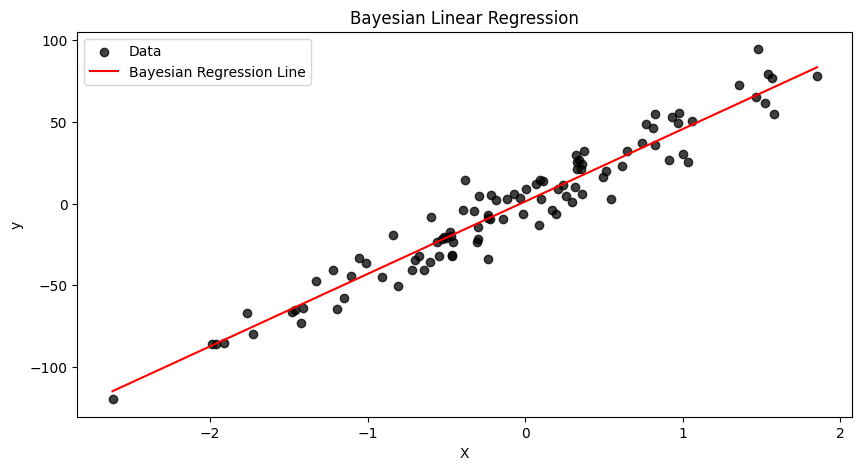

In [5]:
# Plot data and regression line
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Data", color="black", alpha=0.75)
x_range = jnp.linspace(X.min(), X.max(), 100)
y_pred = samples["slope"].mean() * x_range + samples["intercept"].mean()
plt.plot(x_range, y_pred, label="Bayesian Regression Line", color="red")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Linear Regression")
plt.show()

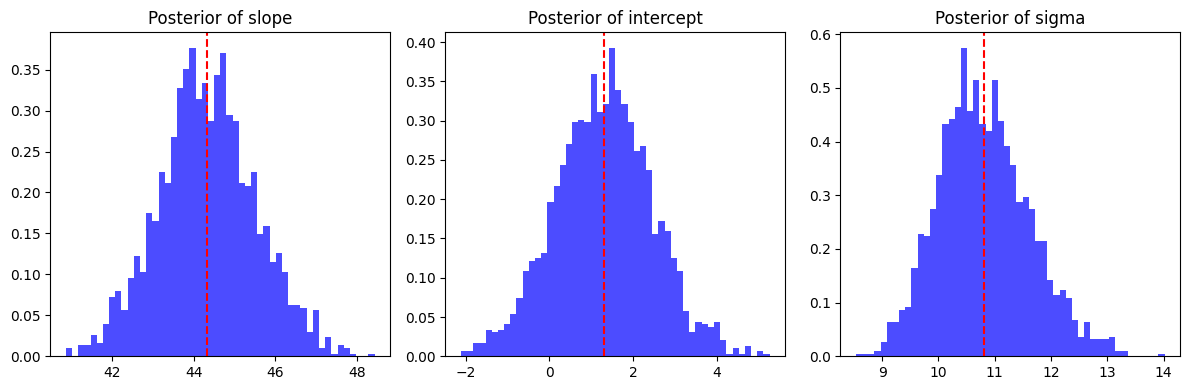

In [6]:
# Plot posterior distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, param in zip(axes, ["slope", "intercept", "sigma"]):
    ax.hist(samples[param], bins=50, density=True, alpha=0.7, color="blue")
    ax.set_title(f"Posterior of {param}")
    ax.axvline(samples[param].mean(), color="red", linestyle="dashed")
plt.tight_layout()
plt.show()

In [7]:
def predict(
    model: Callable, X_new: jax.Array, samples: dict[str, jax.Array]
) -> jax.Array:
    """Predictive function to generate posterior predictive samples.

    Args:
        model: Callable function that defines the model.
        X_new: Array of new input data.
        samples: Dictionary of posterior samples.

    Returns:
        Array of posterior predictive samples of shape ``(num_samples, len(X_new))``.
    """
    predictive = Predictive(model, samples)
    pred_samples = predictive(random.PRNGKey(1), X_new)["obs"]
    return pred_samples


# Generate new test points for inference
X_test = jnp.linspace(X.min(), X.max(), 100)


# Get posterior predictive samples
y_pred_samples = predict(model, X_test, samples)

# Compute mean and 95% confidence interval.
# We aggregate over axis=0, which is the MCMC sampling axis
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_low, y_pred_high = jnp.percentile(y_pred_samples, np.array([2.5, 97.5]), axis=0)

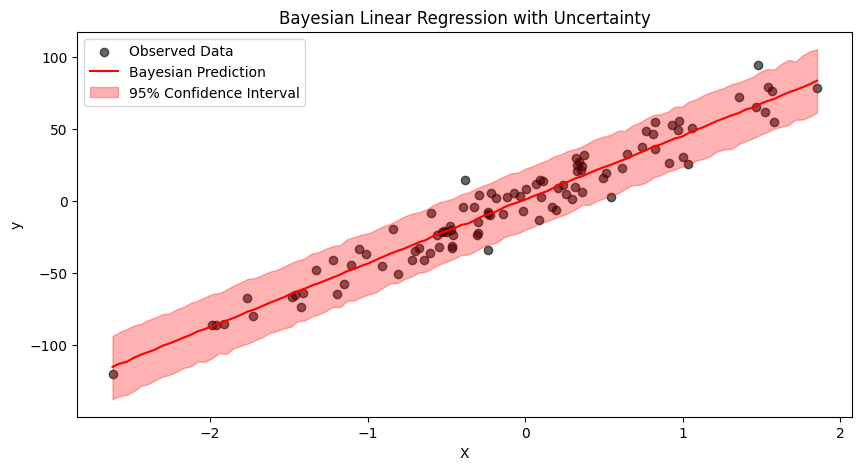

In [8]:
# Plot predictions with confidence interval
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Observed Data", color="black", alpha=0.6)
plt.plot(X_test, y_pred_mean, label="Bayesian Prediction", color="red")
plt.fill_between(
    X_test,
    y_pred_low,
    y_pred_high,
    color="red",
    alpha=0.3,
    label="95% Confidence Interval",
)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Linear Regression with Uncertainty")
plt.show()